<a href="https://colab.research.google.com/github/JFMitu/JFMitu/blob/main/Data2023Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from torchvision.models import inception_v3
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from torch.utils.data import random_split

In [13]:
# Set random seed for reproducibility
torch.manual_seed(42)


In [14]:
# Define paths for the dataset
data_dir = '/content/drive/MyDrive/RiceLeafsDisease2023'
batch_size = 32

In [15]:

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the entire dataset from Google Drive
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

In [16]:
import random
from tabulate import tabulate

# Create dictionaries to store data for train, validation, and test splits for each class
train_class_data = {class_idx: [] for class_idx in range(len(dataset.classes))}
val_class_data = {class_idx: [] for class_idx in range(len(dataset.classes))}
test_class_data = {class_idx: [] for class_idx in range(len(dataset.classes))}

# Define the proportions for train, validation, and test
train_proportion = 0.70
val_proportion = 0.15
test_proportion = 0.15

# Split the data for each class while ensuring balance
for class_idx in range(len(dataset.classes)):
    class_data = [(data, target) for data, target in dataset if target == class_idx]
    random.shuffle(class_data)  # Shuffle the data for each class

    total_samples = len(class_data)
    train_size = int(train_proportion * total_samples)
    val_test_size = int(val_proportion * total_samples)

    train_class_data[class_idx] = class_data[:train_size]
    val_class_data[class_idx] = class_data[train_size:(train_size + val_test_size)]
    test_class_data[class_idx] = class_data[(train_size + val_test_size):(train_size + 2*val_test_size)]

# Merge data for all classes into train, validation, and test sets
train_data = [item for sublist in train_class_data.values() for item in sublist]
val_data = [item for sublist in val_class_data.values() for item in sublist]
test_data = [item for sublist in test_class_data.values() for item in sublist]

# Define data loaders for each set
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


# Print the counts for each class in each set in a tabular form
print("Class-wise Data:")
table_data = []
for class_idx in range(len(dataset.classes)):
    class_name = dataset.classes[class_idx]
    train_count = len(train_class_data[class_idx])
    val_count = len(val_class_data[class_idx])
    test_count = len(test_class_data[class_idx])
    table_data.append([class_name, train_count, val_count, test_count])

# Create headers for the table
headers = ["Class", "Train Sample", "Validation Sample", "Test Sample"]







Class-wise Data:


In [17]:
# Print the tabulated data
print(tabulate(table_data, headers, tablefmt='grid'))

+-----------------------+----------------+---------------------+---------------+
| Class                 |   Train Sample |   Validation Sample |   Test Sample |
+=======================+================+=====================+===============+
| Bacterial Leaf Blight |            306 |                  65 |            65 |
+-----------------------+----------------+---------------------+---------------+
| Brown Spot            |            306 |                  65 |            65 |
+-----------------------+----------------+---------------------+---------------+
| Healthy               |            306 |                  65 |            65 |
+-----------------------+----------------+---------------------+---------------+
| Leaf Blast            |            306 |                  65 |            65 |
+-----------------------+----------------+---------------------+---------------+
| Leaf Scald            |            306 |                  65 |            65 |
+-----------------------+---

In [18]:
   # Get the total number of classes and total number of images
total_classes = len(dataset.classes)
total_images = len(dataset)

# Get the total number of images in the train, validation, and test sets
total_train_images = len(train_data)
total_val_images = len(val_data)
total_test_images = len(test_data)

print(f"Total Classes: {total_classes}")
print(f"Total Images: {total_images}")

print(f"Total Train Images: {total_train_images}")
print(f"Total Validation Images: {total_val_images}")
print(f"Total Test Images: {total_test_images}")

Total Classes: 6
Total Images: 2628
Total Train Images: 1836
Total Validation Images: 390
Total Test Images: 390


In [22]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model
inception_model = InceptionV3(weights='imagenet')
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Print model summary
inception_model.summary()

87910968/87910968 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)        

In [25]:
!pip install torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 2.2 MB/s eta 0:00:00


In [26]:
from timm.models.inception_v3 import inception_v3
class inception_v3(nn.Module):
    def __init__(self, num_classes):
        super(inception_v3, self).__init__()
        self.inception_v3 = models.inception_v3(pretrained=True)
        in_features = self.inception_v3.fc.in_features
        self.inception_v3.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.inception_v3(x)

In [27]:
import timm
import torch.nn as nn
import torch.optim as optim

# Define the model architecture (timm's Inception V3)
model = timm.create_model('inception_v3', pretrained=True)

num_classes = len(dataset.classes)

model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the final fully connected layer

# Move the model to a suitable device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

InceptionV3(
  (Conv2d_1a_3x3): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2a_3x3): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2b_3x3): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size

In [28]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [29]:
# Training loop
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_accuracies = []  # List to store testing accuracies for each epoch

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions_train = 0
    total_samples_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_samples_train += labels.size(0)
        correct_predictions_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = correct_predictions_train / total_samples_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples_val += labels.size(0)
            correct_predictions_val += (predicted == labels).sum().item()

    val_losses.append(running_val_loss / len(val_loader))
    val_accuracy = correct_predictions_val / total_samples_val
    val_accuracies.append(val_accuracy)

    # Testing loop
    model.eval()
    correct_predictions_test = 0
    total_samples_test = 0
    actual_labels_test = []
    predicted_labels_test = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_samples_test += labels.size(0)
            correct_predictions_test += (predicted == labels).sum().item()

            # Append actual and predicted labels for testing
            actual_labels_test += labels.cpu().numpy().tolist()
            predicted_labels_test += predicted.cpu().numpy().tolist()

    test_accuracy = correct_predictions_test / total_samples_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses[-1]:.6f} - Train Acc: {train_accuracy * 100:.2f}% - Val Loss: {val_losses[-1]:.6f} - Val Acc: {val_accuracy * 100:.2f}% - Test Acc: {test_accuracy * 100:.2f}%")


print("Finished Training")


Epoch [1/20] - Train Loss: 1.302577 - Train Acc: 57.84% - Val Loss: 0.647217 - Val Acc: 85.64% - Test Acc: 86.67%
Epoch [2/20] - Train Loss: 0.456735 - Train Acc: 87.69% - Val Loss: 0.259093 - Val Acc: 91.28% - Test Acc: 94.36%
Epoch [3/20] - Train Loss: 0.227053 - Train Acc: 93.79% - Val Loss: 0.160205 - Val Acc: 94.62% - Test Acc: 96.92%
Epoch [4/20] - Train Loss: 0.128425 - Train Acc: 96.68% - Val Loss: 0.112190 - Val Acc: 96.41% - Test Acc: 97.69%
Epoch [5/20] - Train Loss: 0.079909 - Train Acc: 98.47% - Val Loss: 0.091497 - Val Acc: 97.18% - Test Acc: 97.44%
Epoch [6/20] - Train Loss: 0.068963 - Train Acc: 98.58% - Val Loss: 0.095660 - Val Acc: 97.18% - Test Acc: 97.95%
Epoch [7/20] - Train Loss: 0.046018 - Train Acc: 99.35% - Val Loss: 0.073883 - Val Acc: 97.44% - Test Acc: 97.44%
Epoch [8/20] - Train Loss: 0.045995 - Train Acc: 99.07% - Val Loss: 0.062764 - Val Acc: 98.21% - Test Acc: 97.95%
Epoch [9/20] - Train Loss: 0.035078 - Train Acc: 99.51% - Val Loss: 0.074400 - Val Acc: 

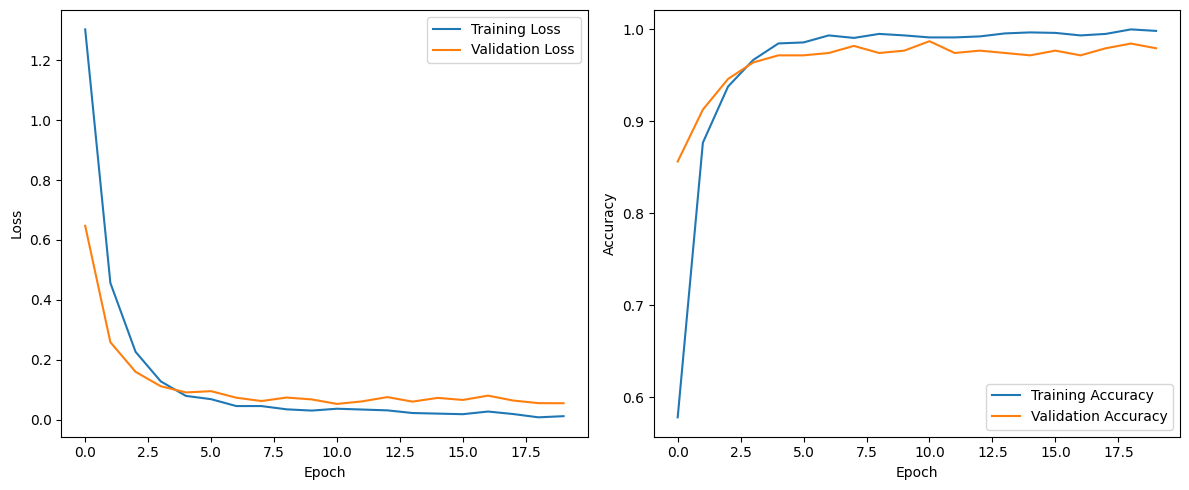

In [30]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

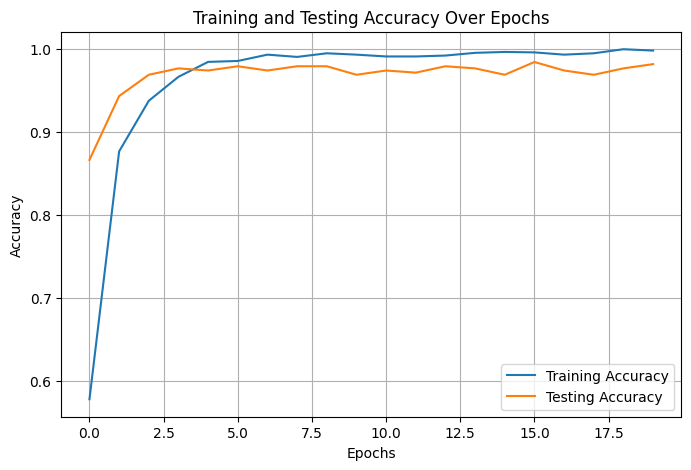

In [31]:
# Plot the training and testing accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
!pip install tabulate
from tabulate import tabulate

# ...

# Convert actual_labels_test and predicted_labels_test to NumPy arrays for further analysis if needed
actual_labels_test = np.array(actual_labels_test)
predicted_labels_test = np.array(predicted_labels_test)

# Create a table with the data
table_data = []
for i in range(len(actual_labels_test)):
    actual_class = dataset.classes[actual_labels_test[i]]
    predicted_class = dataset.classes[predicted_labels_test[i]]
    table_data.append([i + 1, predicted_class, actual_class])

# Create headers for the table
headers = ["Sample", "Predicted Class", "Actual Class"]

# Print the table
print(tabulate(table_data, headers, tablefmt='grid'))

# Calculate the total number of correct samples for testing
total_correct_test = np.sum(actual_labels_test == predicted_labels_test)

# Print the total number of correct samples
print("Total Correct Samples (Testing):", total_correct_test)

+----------+-----------------------+-----------------------+
|   Sample | Predicted Class       | Actual Class          |
+==========+=======================+=======================+
|        1 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        2 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        3 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        4 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        5 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        6 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        7 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+------------

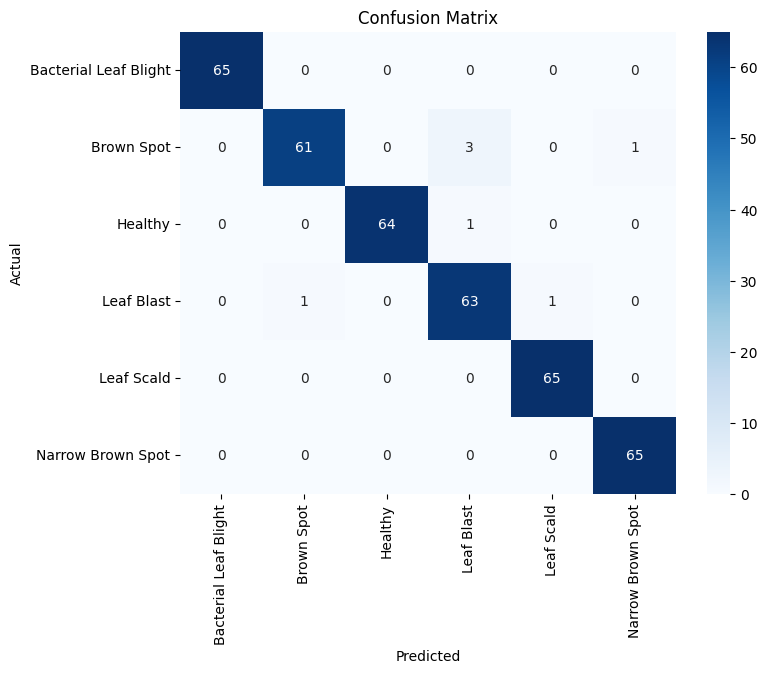

In [33]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
confusion = confusion_matrix(actual_labels_test, predicted_labels_test)

# Get class labels (assuming you have them)
class_labels = [str(i) for i in range(len(confusion))]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from tabulate import tabulate

# Calculate confusion matrix
conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

# Calculate classification report
class_report = classification_report(actual_labels_test, predicted_labels_test, target_names=dataset.classes, output_dict=True)


# Create a table with the data
# Create a table with the data
table_data = []
for i, class_name in enumerate(dataset.classes):
    correct_samples = conf_matrix[i, i]
    total_samples = np.sum(conf_matrix[i, :])
    accuracy = correct_samples / total_samples * 100
    precision = class_report[class_name]['precision'] * 100
    recall = class_report[class_name]['recall'] * 100
    f1_score = class_report[class_name]['f1-score'] * 100
    table_data.append([class_name,
                       f"{correct_samples:.2f}",
                       f"{total_samples:.2f}",
                       f"{f1_score:.2f}",
                       f"{precision:.2f}",
                       f"{recall:.2f}",
                       f"{accuracy:.2f}"])


# Create headers for the table
headers = ["Class", "Correct Samples", "Total Samples", "F1 Score (%)", "Precision (%)", "Recall (%)", "Accuracy (%)"]


# Print the table
print("Class-wise Metrics:")
print(tabulate(table_data, headers, tablefmt='grid'))

# Calculate overall precision, recall, and F1-score
overall_precision = class_report['weighted avg']['precision'] * 100
overall_recall = class_report['weighted avg']['recall'] * 100
overall_f1_score = class_report['weighted avg']['f1-score'] * 100
overall_accuracy = accuracy_score(actual_labels_test, predicted_labels_test) * 100


# Print overall metrics
print(f"Overall Precision: {overall_precision:.2f}%")
print(f"Overall Recall: {overall_recall:.2f}%")
print(f"Overall F1-Score: {overall_f1_score:.2f}%")
print(f"Overall Accuracy: {overall_accuracy:.2f}%")




Class-wise Metrics:
+-----------------------+-------------------+-----------------+----------------+-----------------+--------------+----------------+
| Class                 |   Correct Samples |   Total Samples |   F1 Score (%) |   Precision (%) |   Recall (%) |   Accuracy (%) |
+=======================+===================+=================+================+=================+==============+================+
| Bacterial Leaf Blight |                65 |              65 |         100    |          100    |       100    |         100    |
+-----------------------+-------------------+-----------------+----------------+-----------------+--------------+----------------+
| Brown Spot            |                61 |              65 |          96.06 |           98.39 |        93.85 |          93.85 |
+-----------------------+-------------------+-----------------+----------------+-----------------+--------------+----------------+
| Healthy               |                64 |              65 |

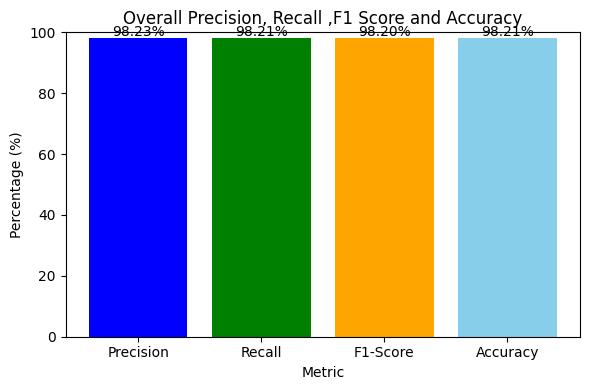

In [45]:
# Create labels and values for the metrics
metrics = ["Precision", "Recall", "F1-Score", "Accuracy"]
values = [overall_precision, overall_recall, overall_f1_score, overall_accuracy]

# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'skyblue'])
plt.ylim(0, 100)  # Set the y-axis limit to 0-100 for percentage values
plt.title('Overall Precision, Recall ,F1 Score and Accuracy')
plt.xlabel('Metric')
plt.ylabel('Percentage (%)')

# Display the values on top of the bars
for i, v in enumerate(values):
    plt.text(i, v -0.5, f'{v:.2f}%', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

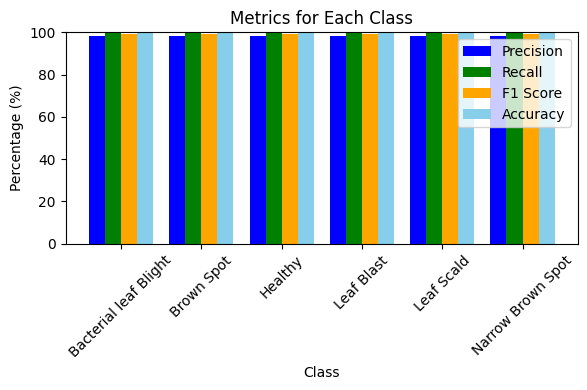

In [59]:

import matplotlib.pyplot as plt
import numpy as np

# ... (previous code remains the same)

class_accuracy = correct_samples / total_samples * 100
class_precision = class_report[class_name]['precision'] * 100
class_recall = class_report[class_name]['recall'] * 100
class_f1_score = class_report[class_name]['f1-score'] * 100
# Create an array for the x-axis positions of bars
x = np.arange(len(class_names))

# Set the width of the bars
bar_width = 0.2

# Create a figure
plt.figure(figsize=(6, 4))


# Plot precision for each class
plt.bar(x - bar_width * 1.5, class_precision, width=bar_width, label='Precision', color='blue')

# Plot recall for each class
plt.bar(x - bar_width * 0.5, class_recall, width=bar_width, label='Recall', color='green')

# Plot F1-score for each class
plt.bar(x + bar_width * 0.5, class_f1_score, width=bar_width, label='F1 Score', color='orange')

# Plot accuracy for each class
plt.bar(x + bar_width * 1.5, class_accuracy, width=bar_width, label='Accuracy', color='skyblue')

# Set x-axis labels and tick positions
plt.xticks(x, class_names, rotation=45)

# Set y-axis limit to 0-100 for percentage values
plt.ylim(0, 100)

# Add legend
plt.legend()

# Set labels and title
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.title('Metrics for Each Class')

# Show the plot
plt.tight_layout()
plt.show()